In [1]:
# import ee
# import geemap
# import wxee
from pathlib import Path

import geopandas as gpd
import richdem as rd
import numpy as np
import rioxarray
import xarray as xr
import elevation
import cython

import jupyter_black

jupyter_black.load(lab=False)

In [2]:
gdf = gpd.read_file("roi.shp")

In [3]:
srtmpath = Path() / "srtmroi.tif"

elevation.clip(*gdf.bounds.values, margin="0.5", output=srtmpath.absolute())

make: Entering directory '/home/feefladder/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/feefladder/.cache/elevation/SRTM1'
make: Entering directory '/home/feefladder/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/feefladder/.cache/elevation/SRTM1'
make: Entering directory '/home/feefladder/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.06fabf26b534498c89073054a656c678.vrt
make: Leaving directory '/home/feefladder/.cache/elevation/SRTM1'
make: Entering directory '/home/feefladder/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 36.643102 10.06081 37.650054 9.049214 SRTM1.06fabf26b534498c89073054a656c678.vrt /media/feefladder/c/Git/ahf-preprocess/notebooks/srtmroi.tif
rm -f SRTM1.06fabf26b534498c89073054a656c678.vrt
make: Leaving directory '/home/feefladder/.cache/elevation/SRTM1'


In [4]:
ds = rioxarray.open_rasterio(srtmpath).to_dataset(name="elevation").astype("float32")
ds.elevation

<xarray.DataArray 'elevation' (band: 1, y: 3642, x: 3625)>
array([[[1778., 1776., 1772., ..., 1747., 1751., 1754.],
        [1780., 1778., 1775., ..., 1751., 1756., 1760.],
        [1779., 1778., 1773., ..., 1760., 1765., 1769.],
        ...,
        [1990., 1990., 1991., ..., 1794., 1775., 1767.],
        [1991., 1989., 1988., ..., 1808., 1785., 1769.],
        [1988., 1986., 1984., ..., 1816., 1793., 1777.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 36.64 36.64 36.64 36.64 ... 37.65 37.65 37.65 37.65
  * y            (y) float64 10.06 10.06 10.06 10.06 ... 9.05 9.05 9.05 9.049
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
ds = ds.squeeze()

In [6]:
rdsheds = rd.rdarray(
    ds.elevation.fillna(ds.elevation._FillValue), no_data=ds.elevation._FillValue
)
ds["filled"] = ds.elevation
ds.filled.data = rd.FillDepressions(rdsheds, epsilon=True, in_place=False)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 3.46959 s===================== ] (99% - 0.0s - 1 threads)
m Cells processed = 13202250
m Cells in pits = 1316248


In [7]:
ds.filled

<xarray.DataArray 'filled' (y: 3642, x: 3625)>
array([[1778., 1776., 1772., ..., 1747., 1751., 1754.],
       [1780., 1778., 1775., ..., 1751., 1756., 1760.],
       [1779., 1778., 1773., ..., 1760., 1765., 1769.],
       ...,
       [1990., 1990., 1991., ..., 1794., 1775., 1767.],
       [1991., 1989., 1988., ..., 1808., 1785., 1769.],
       [1988., 1986., 1984., ..., 1816., 1793., 1777.]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 36.64 36.64 36.64 36.64 ... 37.65 37.65 37.65 37.65
  * y            (y) float64 10.06 10.06 10.06 10.06 ... 9.05 9.05 9.05 9.049
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
clipped = xr.ones_like(ds.elevation, dtype=np.ubyte).rio.clip(gdf.buffer(0.001))
ds["mask"] = clipped
ds.mask.fillna(0)
ds["mask"] = ds["mask"].fillna(0)

/home/feefladder/miniconda3/envs/thesis/lib/python3.10/site-packages/rioxarray/raster_writer.py:115: UserWarning: The nodata value (-32768.0) has been automatically changed to (0) to match the dtype of the data.
  warnings.warn(


In [9]:
print(bool(np.nan))

True


In [10]:
%load_ext Cython

In [11]:
%%cython -+
from libcpp.queue cimport queue
from libcpp.vector cimport vector
from libc.math cimport isnan

cdef struct xypoint:
    long x
    long y


#     3 2 1
#     4 X 0
#     5 6 7
cdef int[8] dx = [1, 1, 0, -1, -1, -1, 0, 1]
cdef int[8] dy = [0, 1, 1, 1, 0, -1, -1, -1]
    
def upslope_cells(double[:,:] mask, float[:,:] dem) -> void:
    cdef queue[xypoint] qu
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] != 0:
                qu.push(xypoint(i,j))

    while not qu.empty():
        point = qu.front()
        qu.pop()
        
        for i in range(8):
            x = point.x + dx[i]
            y = point.y + dy[i]
            if x < 0 or x > mask.shape[0]:
                continue
            if y < 0 or y > mask.shape[1]:
                continue
            if mask[x,y] == 0:
                if dem[x,y] > dem[point.x,point.y]:
                    qu.push(xypoint(x,y))
                    mask[x,y] += 1

In [12]:
dx = [1, 1, 0, -1, -1, -1, 0, 1]
dy = [0, 1, 1, 1, 0, -1, -1, -1]


def slow_upslope_cells(mask, dem):
    qu = []
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x, y] != 0:
                qu.append([x, y])

    while len(qu) != 0:
        point = qu.pop()

        for i in range(8):
            x = point[0] + dx[i]
            y = point[1] + dy[i]
            if x < 0 or x > mask.shape[0]:
                continue
            if y < 0 or y > mask.shape[1]:
                continue
            if mask[x, y] == 0:
                if dem[x, y] > dem[point[0], point[1]]:
                    qu.push([x, y])
                    mask[x, y] += 1

In [13]:
upslope_cells(ds.mask.squeeze().data, ds.filled.squeeze().data)

In [14]:
# %timeit slow_upslope_cells(ds.mask.squeeze().data, ds.filled.squeeze().data)

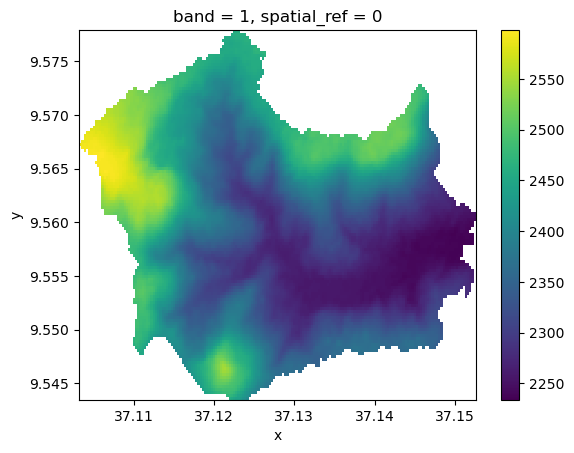

In [15]:
extracted = (
    xr.where(ds.mask != 0, ds.elevation, np.nan)
    .dropna("x", how="all")
    .dropna("y", how="all")
    .rio.write_crs(4326)
)
extracted.plot()
extracted = extracted.fillna(-9999).rio.write_nodata(-9999)

In [17]:
extracted.rio.to_raster("hadocha_dem.tif")